In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [5]:
data = pd.read_excel('data_DP.xlsx')
data.drop(axis=1, inplace=True, columns=['-logC','MaxWaveLength'])
data

,Concentration,320,321,322,323,324,325,326,327,328,...,994,995,996,997,998,999,1000,MaxPeakAbs,time,Integral
0,5,0.387,0.390,0.398,0.406,0.416,0.428,0.440,0.446,0.453,...,0.183,0.182,0.181,0.179,0.178,0.177,0.176,0.849,3.0,371.98
1,10,0.380,0.386,0.394,0.401,0.411,0.423,0.434,0.437,0.444,...,0.290,0.288,0.286,0.283,0.281,0.279,0.277,0.832,3.0,425.36
2,15,0.375,0.380,0.389,0.395,0.406,0.417,0.427,0.432,0.437,...,0.354,0.352,0.349,0.346,0.344,0.341,0.339,0.796,3.0,421.06
3,20,0.303,0.311,0.319,0.326,0.337,0.349,0.362,0.366,0.373,...,0.354,0.351,0.348,0.346,0.344,0.341,0.339,0.799,3.0,417.11
4,25,0.306,0.313,0.322,0.329,0.341,0.353,0.365,0.369,0.376,...,0.363,0.360,0.357,0.354,0.352,0.350,0.347,0.825,3.0,425.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,220,0.237,0.240,0.248,0.255,0.266,0.278,0.296,0.302,0.316,...,0.354,0.351,0.347,0.344,0.341,0.338,0.336,0.890,NaN,NaN
195,240,0.245,0.250,0.259,0.264,0.278,0.292,0.309,0.317,0.330,...,0.341,0.338,0.334,0.331,0.328,0.325,0.323,0.920,NaN,NaN
196,260,0.262,0.266,0.275,0.283,0.296,0.311,0.328,0.334,0.348,...,0.310,0.308,0.304,0.301,0.298,0.295,0.293,0.927,NaN,NaN
197,280,0.260,0.266,0.274,0.282,0.296,0.309,0.328,0.336,0.349,...,0.297,0.294,0.290,0.288,0.285,0.282,0.280,0.935,NaN,NaN


In [6]:
X = data.iloc[:,1:-3]
X.columns = X.columns.astype(str)
y = data.iloc[:,0]
X.shape

(199, 681)

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
st = StandardScaler()
X = st.fit_transform(X)
y = st.fit_transform(np.array(y).reshape(-1,1))
X.shape

(199, 681)

In [8]:
from sklearn.ensemble import IsolationForest
print(X.shape,y.shape)
iso = IsolationForest(contamination=0.05)
yhat = iso.fit_predict(X)
mask = yhat != -1
X, y = X[mask, :], y[mask]
print(X.shape, y.shape)

(199, 681) (199, 1)
(189, 681) (189, 1)


In [131]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, random_state=2, test_size= 0.2)
# X_train.shape

In [9]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

fs_mut = SelectKBest(score_func=mutual_info_regression, k='all')
fs_mut.fit(X, y)
X_train_fs_m_info = fs_mut.transform(X)

fs_f = SelectKBest(score_func=f_regression, k='all')
fs_f.fit(X, y)
X_train_fs_f_reg = fs_f.transform(X)


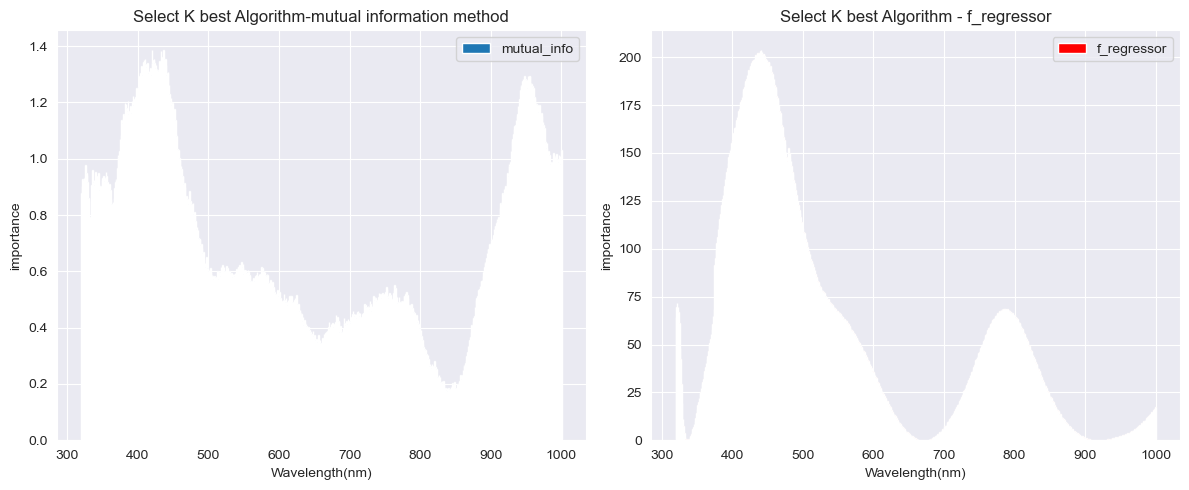

In [10]:
plt.figure(figsize=(12, 5)) 


plt.subplot(1, 2, 1)
plt.bar([i + 320 for i in range(len(fs_mut.scores_))], fs_mut.scores_, label='mutual_info')
plt.title('Select K best Algorithm-mutual information method')
plt.xlabel('Wavelength(nm)')
plt.ylabel('importance')
plt.legend()

plt.subplot(1, 2, 2) 
plt.bar([i + 320 for i in range(len(fs_f.scores_))], fs_f.scores_, label='f_regressor', color='red')
plt.title('Select K best Algorithm - f_regressor')
plt.xlabel('Wavelength(nm)')
plt.ylabel('importance')
plt.legend()

plt.tight_layout()

plt.show()

In [11]:
y = np.reshape(y, (y.shape[0],))

y.shape

(189,)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import RepeatedKFold, cross_validate
num_features = [i for i in range(5, X.shape[1],5)]
mean_r2_mut_train = []
mean_rmse_mut_train = []
mean_r2_f_train = []
mean_rmse_f_train = []
mean_r2_mut_test = []
mean_rmse_mut_test = []
mean_r2_f_test = []
mean_rmse_f_test = []
cv_lasso = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=3)
for i in num_features:
    model = LassoLarsCV(cv=cv_lasso,n_jobs=-1)
    fs_mut = SelectKBest(score_func=mutual_info_regression, k=i)
    pipeline = Pipeline(steps=[('SelectKbest',fs_mut), ('Linear_model', model)])
    scores_mut = cross_validate(pipeline, X, y, scoring=['r2','neg_root_mean_squared_error'], cv=cv, n_jobs=-1, return_train_score=True)
    mean_r2_mut_train.append(np.mean(scores_mut['train_r2']))
    mean_rmse_mut_train.append((-1) * np.mean(scores_mut['train_neg_root_mean_squared_error']))
    mean_r2_mut_test.append(np.mean(scores_mut['test_r2']))
    mean_rmse_mut_test.append((-1) * np.mean(scores_mut['test_neg_root_mean_squared_error']))
    print('Train: >%d %.3f (%.3f)' % (i, np.mean(scores_mut['train_r2']), np.std(scores_mut['train_r2'])))
    print('Test:  >%d %.3f (%.3f)' % (i, np.mean(scores_mut['test_r2']), np.std(scores_mut['test_r2'])))

for i in num_features:
    model = LassoLarsCV(cv=cv_lasso,n_jobs=-1)
    fs_f = SelectKBest(score_func=f_regression, k=i)
    pipeline = Pipeline(steps=[('SelectKbest',fs_f), ('Linear_model', model)])
    scores_f = cross_validate(pipeline, X, y, scoring=['r2','neg_root_mean_squared_error'], cv=cv, n_jobs=-1, return_train_score=True)
    mean_r2_f_train.append(np.mean(scores_f['train_r2']))
    mean_rmse_f_train.append((-1) * np.mean(scores_f['train_neg_root_mean_squared_error']))
    mean_r2_f_test.append(np.mean(scores_f['test_r2']))
    mean_rmse_f_test.append((-1) * np.mean(scores_f['test_neg_root_mean_squared_error']))
    print('Train: >%d %.3f (%.3f)' % (i, np.mean(scores_f['train_r2']), np.std(scores_f['train_r2'])))
    print('Test:  >%d %.3f (%.3f)' % (i, np.mean(scores_f['test_r2']), np.std(scores_f['test_r2'])))




Train: >5 0.569 (0.042)
Test:  >5 0.521 (0.147)
Train: >10 0.597 (0.050)
Test:  >10 0.544 (0.144)
Train: >15 0.610 (0.043)
Test:  >15 0.551 (0.150)
Train: >20 0.615 (0.046)
Test:  >20 0.559 (0.141)
Train: >25 0.644 (0.046)
Test:  >25 0.574 (0.149)
Train: >30 0.669 (0.044)
Test:  >30 0.593 (0.158)
Train: >35 0.669 (0.044)
Test:  >35 0.588 (0.162)
Train: >40 0.687 (0.053)
Test:  >40 0.607 (0.153)
Train: >45 0.699 (0.034)
Test:  >45 0.612 (0.150)
Train: >50 0.709 (0.025)
Test:  >50 0.618 (0.144)
Train: >55 0.722 (0.032)
Test:  >55 0.635 (0.104)
Train: >60 0.734 (0.034)
Test:  >60 0.644 (0.104)
Train: >65 0.749 (0.040)
Test:  >65 0.668 (0.103)
Train: >70 0.769 (0.028)
Test:  >70 0.686 (0.103)
Train: >75 0.780 (0.028)
Test:  >75 0.702 (0.098)
Train: >80 0.805 (0.022)
Test:  >80 0.720 (0.087)
Train: >85 0.815 (0.023)
Test:  >85 0.729 (0.066)
Train: >90 0.821 (0.027)
Test:  >90 0.725 (0.068)
Train: >95 0.817 (0.030)
Test:  >95 0.740 (0.059)
Train: >100 0.827 (0.023)
Test:  >100 0.745 (0.056)


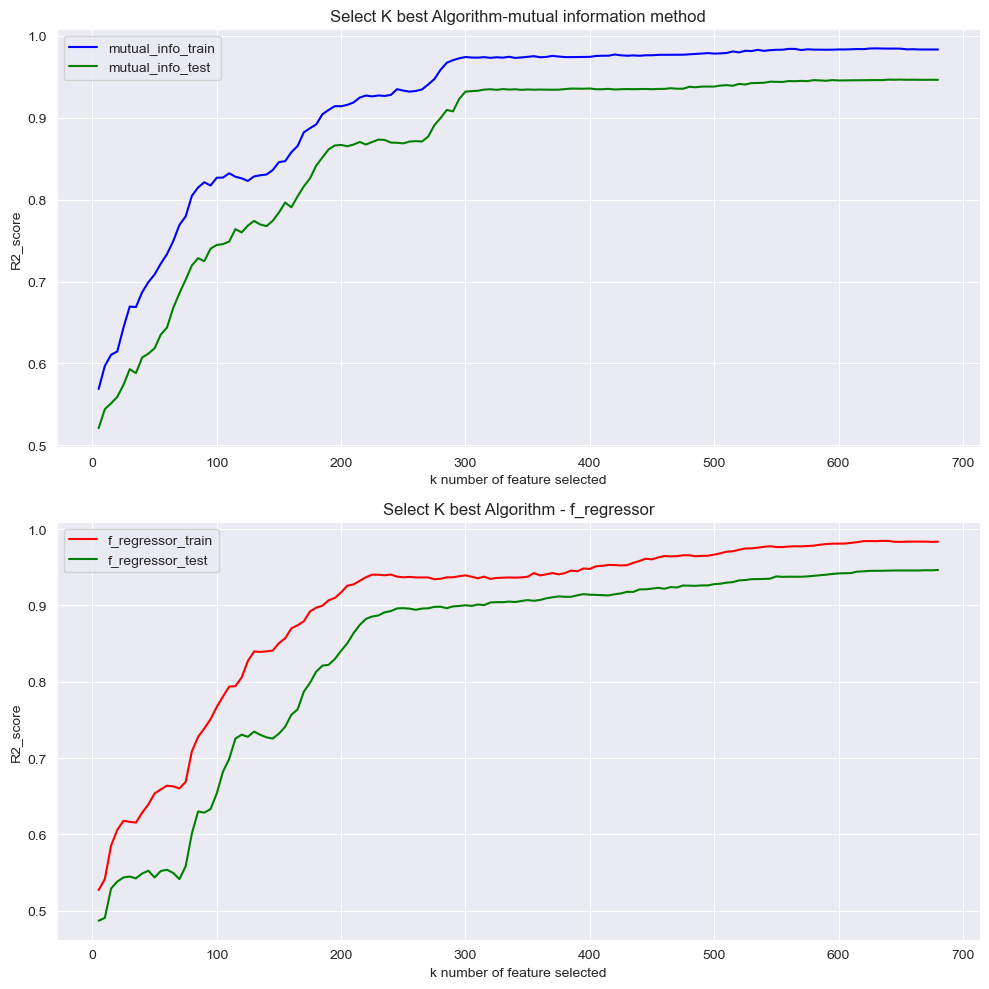

In [13]:
plt.figure(figsize=(10, 10))


plt.subplot(2, 1, 1)
plt.plot(num_features, np.array(mean_r2_mut_train), label='mutual_info_train',color='blue')
plt.plot(num_features, np.array(mean_r2_mut_test), label='mutual_info_test', color='green')
plt.title('Select K best Algorithm-mutual information method')
plt.xlabel('k number of feature selected')
plt.ylabel('R2_score')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(num_features, np.array(mean_r2_f_train), label='f_regressor_train', color='red')
plt.plot(num_features, np.array(mean_r2_f_test), label='f_regressor_test', color='green')
plt.title('Select K best Algorithm - f_regressor')
plt.xlabel('k number of feature selected')
plt.ylabel('R2_score')
plt.legend()

plt.tight_layout()

plt.show()

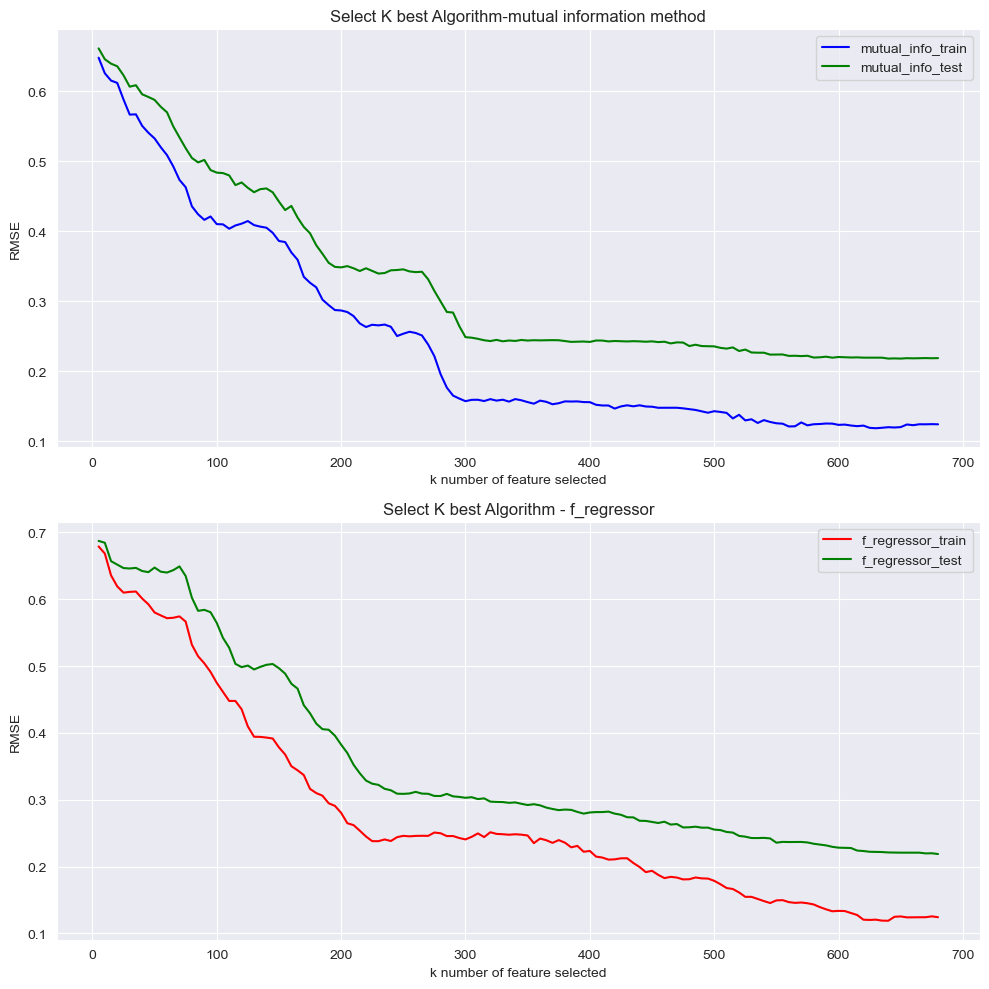

In [14]:
plt.figure(figsize=(10, 10))


plt.subplot(2, 1, 1)
plt.plot(num_features, np.array(mean_rmse_mut_train), label='mutual_info_train',color='blue')
plt.plot(num_features, np.array(mean_rmse_mut_test), label='mutual_info_test', color='green')
plt.title('Select K best Algorithm-mutual information method')
plt.xlabel('k number of feature selected')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(num_features, np.array(mean_rmse_f_train), label='f_regressor_train', color='red')
plt.plot(num_features, np.array(mean_rmse_f_test), label='f_regressor_test', color='green')
plt.title('Select K best Algorithm - f_regressor')
plt.xlabel('k number of feature selected')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()

plt.show()

In [15]:
from sklearn.linear_model import LassoLarsCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import RepeatedKFold, cross_val_score

cv_lasso = RepeatedKFold(n_splits=9, n_repeats=100)
k_320_best = SelectKBest(score_func=mutual_info_regression, k=310)
X_new_train = k_320_best.fit_transform(X,y)

reg = LassoLarsCV(cv=cv_lasso,n_jobs=-1).fit(X_new_train,y)
print(f'r2 score: {reg.score(X_new_train,y)}')
X


r2 score: 0.9694892922634176


array([[ 2.42288154,  2.34665252,  2.33170799, ...,  0.50000231,
         0.49609762,  0.50074861],
       [ 0.46820549,  0.51190216,  0.49029451, ...,  0.50000231,
         0.49609762,  0.50074861],
       [ 0.54965032,  0.56508333,  0.56921223, ...,  0.65179554,
         0.66798983,  0.65432052],
       ...,
       [-0.64487393, -0.68467415, -0.66716539, ..., -0.37280874,
        -0.38246257, -0.38228987],
       [-0.69917049, -0.68467415, -0.69347129, ..., -0.61947274,
        -0.63075132, -0.63184423],
       [-0.31909459, -0.33899655, -0.3251886 , ..., -0.12614475,
        -0.13417382, -0.15193201]])

In [16]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
coefs = sc.fit_transform(reg.coef_.reshape(-1,1))
coefs = coefs.reshape((-1,))


In [17]:
is_selected = k_320_best.get_support()
num_all_features = [i for i in range(320, 1001)]
counter_reg = 0
arr_fig = []
for i in range(len(is_selected)):
    if is_selected[i]:
        arr_fig.append(coefs[counter_reg])
        counter_reg += 1
    else:
        arr_fig.append(0)
arr_fig = np.array(arr_fig)
print(arr_fig.shape)


(681,)


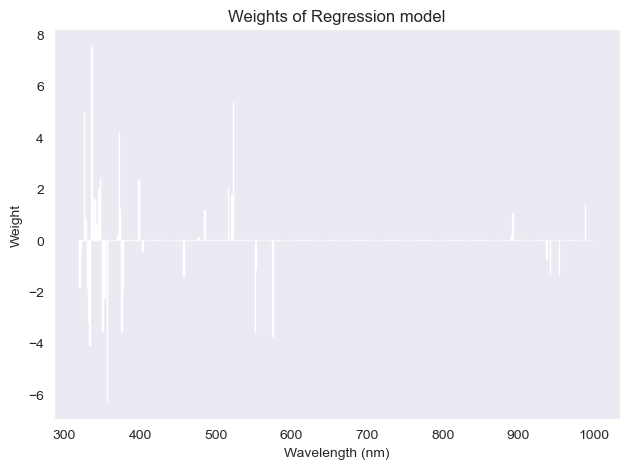

In [18]:
plt.bar(num_all_features,arr_fig, color='red')
plt.title('Weights of Regression model')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Weight')
plt.grid()

plt.tight_layout()

plt.show()

In [19]:
from sklearn.model_selection import cross_validate
X_new_test = k_320_best.transform(X)
results_mut = []
scores_mut = cross_validate(reg, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1,return_train_score=True)
print(np.mean(scores_mut['test_score']))
#print(' %.3f (%.3f)' % ( np.mean(scores_mut), np.std(scores_mut)))

-0.21897623430835547


# Using RFECV and Random Forest Regressor for feature selection


In [20]:
from numpy.linalg import norm
y_pred = reg.predict(X_new_train)

LOD = (3.3 * np.std(y_pred)) / norm(reg.coef_)
LOD

0.41103731464076265